In [1]:
%config IPCompleter.greedy=True

In [2]:
import sys
import torch

In [3]:
sys.path.append("../")
sys.argv = ["foo","-r","preSelection"]

In [4]:
import modules

In [5]:
import Driver
from dataset import bbMeT_NN
from Driver import logging
msg=logging.getLogger("Train")

Driver       :: INFO     ::       Setting up Driver from /nfs/dust/atlas/user/hteagle/PyAnalysisUtils/Driver.py
Driver       :: INFO     ::       NO VARIABLES SUPPLIED ON THE COMMAND LINE, JUST DRAWING ONE BIN
Driver       :: INFO     ::       Variables from the command line...
Driver       :: INFO     ::       	 {'var': '1', 'nbins': 1, 'xmin': 0.0, 'xmax': 2.0}


In [6]:
import NN_driver
NN_driver.load_NN_variables()

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = bbMeT_NN(root='data', device=device, transform=None)
device

DatasetLoader :: INFO     ::       Attempt to load:/nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/data_Wh_21_2_112_reco_sig.pt


Welcome to JupyROOT 6.18/00
desy path: /nfs/dust/atlas/user/hteagle/Wh_samples/Wh_21.2.112/MC/


device(type='cuda', index=0)

In [8]:
num_workers = NN_driver.num_workers
batch_size = NN_driver.batch_size
split_fraction = NN_driver.split_fraction
epochs = NN_driver.epochs
lr = NN_driver.lr
weight_decay=NN_driver.weight_decay
class_names=NN_driver.class_names
num_classes = len(NN_driver.class_names)
doReWeight=NN_driver.doReWeight
doWeighted=NN_driver.doWeighted

In [9]:
# import numpy as np
# from torch.utils.data.sampler import SubsetRandomSampler
# indices = list(range(len(dataset)))
# split = int(np.floor(split_fraction * len(dataset)))
# train_indices,test_indices = indices[:split], indices[split:]
epochs=30
# train_sampler = SubsetRandomSampler(train_indices)
# test_sampler = SubsetRandomSampler(test_indices)

In [10]:
model = modules.Cat(X_size=len(dataset.X_data[0]),num_classes=num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr , weight_decay=weight_decay)
model=model.float()

In [11]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
indices = list(range(len(dataset)))
split = int(np.floor(split_fraction * len(dataset)))
train_indices,test_indices = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=batch_size,sampler=train_sampler, drop_last=True)
test_loader = DataLoader(dataset, batch_size=batch_size,sampler=test_sampler, drop_last=False)
#%load_ext tensorboard
import XGB_board
xmini,ymini,wmini = next(iter(train_loader))
board = XGB_board.board_object(model,xmini=xmini, device=device, output_dir="full_log/")
#%tensorboard --logdir board.save_dir

New output:full_log/2020-08-20/12:46:29.156165


../modules.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.functional.softmax(x)## When training/calculating losses using CrossEntropyLoss we should feed it raw logits, it applies softmax itself. When applying/getting probabilites, we should switch this on..annoying


Got Pytorch model


In [12]:
%load_ext tensorboard
%tensorboard --logdir  full_log --bind_all

Reusing TensorBoard on port 6006 (pid 5013), started 13:08:15 ago. (Use '!kill 5013' to kill it.)

In [13]:
from datetime import datetime
from tqdm import tqdm
for epoch in tqdm(range(epochs)):
    model.train()
    for local_batch, local_labels, local_weights in train_loader:
        local_batch, local_labels, local_weights = local_batch.to(device), local_labels.to(device), local_weights.to(device)
        optimiser.zero_grad()
        if doWeighted:
            criterion = torch.nn.CrossEntropyLoss( weight = ut.get_batch_weights(local_labels,local_weights,(len(class_names)),doMonoSigWgt))
        elif doReWeight:
            criterion = torch.nn.CrossEntropyLoss( weight = class_weights)
        out = model(local_batch.float())
        loss = criterion(out, local_labels)
        loss.backward()
        optimiser.step()
    model.eval()
    with torch.no_grad():
        if doWeighted:
            valid_loss = 0
            train_loss = 0
            for xb, yb, wb in test_loader:
                criterion = torch.nn.CrossEntropyLoss( weight = ut.get_batch_weights(yb,wb,(len(class_names)),doMonoSigWgt))
                valid_loss = valid_loss + criterion(model(xb.float()), yb)
            for xb, yb, wb in train_loader:
                criterion = torch.nn.CrossEntropyLoss( weight = ut.get_batch_weights(yb,wb,(len(class_names)),doMonoSigWgt))
                train_loss = train_loss + criterion(model(xb.float()), yb)
        else:
            valid_loss = sum(criterion(model(xb.float()), yb) for xb, yb, wb in test_loader)
            train_loss = sum(criterion(model(xb.float()), yb) for xb, yb, wb in train_loader)
    test_loss = valid_loss/len(test_loader)
    train_loss = train_loss/len(train_loader)
    board.writer.add_scalars("Losses",{"validation_loss/epoch":test_loss,
                                        "train_loss/epoch":train_loss,},epoch)
model.eval() #Start evaluation

100%|██████████| 30/30 [1:18:02<00:00, 156.08s/it]


Cat(
  (dropout10): AlphaDropout(p=0.1, inplace=False)
  (dropout20): AlphaDropout(p=0.2, inplace=False)
  (dropout30): AlphaDropout(p=0.3, inplace=False)
  (linear_input): Linear(in_features=35, out_features=140, bias=True)
  (linear1): Linear(in_features=140, out_features=140, bias=True)
  (linear2): Linear(in_features=140, out_features=140, bias=True)
  (linear3): Linear(in_features=140, out_features=140, bias=True)
  (linear4): Linear(in_features=140, out_features=140, bias=True)
  (linear5): Linear(in_features=140, out_features=140, bias=True)
  (linear_output): Linear(in_features=140, out_features=5, bias=True)
)

In [14]:
import utils.utils as ut
ut.save_model(model, board.save_dir,train_loader)

In [15]:
board.get_inputs(train_loader, test_loader)

Pytorch_board :: INFO     ::       Getting input lists
100%|██████████| 873/873 [01:03<00:00, 13.70it/s]
Pytorch_board :: INFO     ::       Finished getting test inputs
100%|██████████| 3488/3488 [06:40<00:00,  8.71it/s]
Pytorch_board :: INFO     ::       Finished getting train inputs


XGB_board    :: INFO     ::       PValue background KS: 1.0
XGB_board    :: INFO     ::       PValue signal KS: 0.11262550123191739
Info in <TCanvas::Print>: png file full_log/2020-08-20/12:46:29.156165/root_hists.png has been created
Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TCanvas::Print>: png file full_log/2020-08-20/12:46:29.156165/root_norm_hists.png has been created


Time to plot with ROOT: 0:00:39.138722


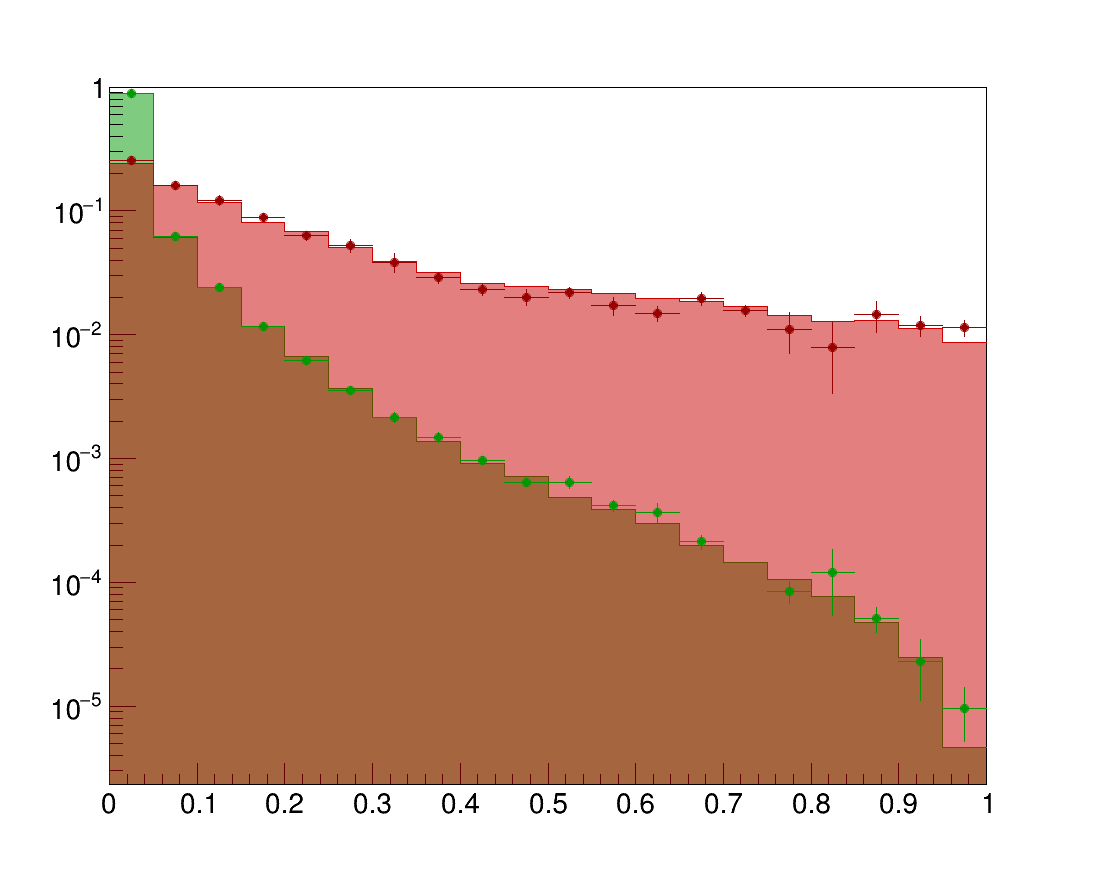

In [16]:
c = board.draw_train_test_root()
c.Draw()

ROC curves per class

In [17]:
%matplotlib inline
import importlib
importlib.reload(XGB_board)
#new_board = XGB_board.board_object(model,xmini=xmini, device=device, output_dir="current_log/")
#new_board.get_inputs(train_loader, test_loader)
auc, curve = board.get_roc(class_ = "Signal")
auc

0.9050232646701489

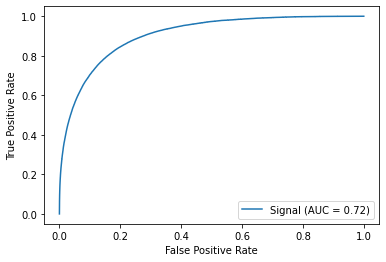

In [18]:
curve.ax_.legend("Signal ROC, ACU: %f"%(auc))
curve.plot()

In [19]:
h_params={}
h_params["learning_rate"] = NN_driver.lr
h_params["batch_size"] = NN_driver.batch_size
h_params["doWeighted"] = NN_driver.doWeighted
h_params["doReWeight"] = NN_driver.doReWeight
h_params["split_fraction"] = NN_driver.split_fraction

In [20]:
metric_params = {}
metric_params["Signal_AUC"]=auc
metric_params["PValue_bkg"]=board.pval_bkg_KS
metric_params["PValue_sig"]=board.pval_sig_KS

In [21]:
board.writer.add_hparams(h_params, metric_params)

Let's do some detailed analysis

In [22]:
to_load = ["C1N2_Wh_300.0_150.0", "C1N2_Wh_350.0_200.0", "C1N2_Wh_400.0_250.0", "C1N2_Wh_450.0_300.0"]
signal_samples = [ dataset.process(single_sample=sam) for sam in to_load]

DatasetLoader :: INFO     ::       Loading a single sample
numexpr.utils :: INFO     ::       Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils :: INFO     ::       NumExpr defaulting to 8 threads.
Samples      :: INFO     ::       
Samples      :: INFO     ::       Looking in path=/nfs/dust/atlas/user/hteagle/Wh_samples/Wh_21.2.112/MC/
Samples      :: INFO     ::       Setup a TChain for sample=C1N2_Wh_300.0_150.0 with treename=CollectionTree_PFlow_
Samples      :: INFO     ::       Adding sample to C1N2_Wh_300.0_150.0/CollectionTree_PFlow_ with pattern=*C1N2_Wh_hbb_300p0_150p0*


Regions: ['preSelection']


Samples      :: INFO     ::       Loaded chain C1N2_Wh_300.0_150.0/CollectionTree_PFlow_ with 11710 events
Samples      :: WARNING  ::       For sample C1N2_Wh_300.0_150.0 a YearWeight of (  mcID==396716  ) ? (year<2017 ? 0.579366 : 0.420634) : year<2017 ? 0.260512 : year==2017 ? 0.318854 : year==2018 ? 0.420634  was set
DatasetLoader :: INFO     ::       Using scaler: /nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/scaler_Wh_21_2_112_reco_sig.save
DatasetLoader :: INFO     ::       Loading a single sample
Samples      :: INFO     ::       
Samples      :: INFO     ::       Looking in path=/nfs/dust/atlas/user/hteagle/Wh_samples/Wh_21.2.112/MC/
Samples      :: INFO     ::       Setup a TChain for sample=C1N2_Wh_350.0_200.0 with treename=CollectionTree_PFlow_
Samples      :: INFO     ::       Adding sample to C1N2_Wh_350.0_200.0/CollectionTree_PFlow_ with pattern=*C1N2_Wh_hbb_350p0_200p0*
Samples      :: INFO     ::       Loaded chain C1N2_Wh_350.0_200.0/CollectionTree

Regions: ['preSelection']


DatasetLoader :: INFO     ::       Using scaler: /nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/scaler_Wh_21_2_112_reco_sig.save
DatasetLoader :: INFO     ::       Loading a single sample
Samples      :: INFO     ::       
Samples      :: INFO     ::       Looking in path=/nfs/dust/atlas/user/hteagle/Wh_samples/Wh_21.2.112/MC/
Samples      :: INFO     ::       Setup a TChain for sample=C1N2_Wh_400.0_250.0 with treename=CollectionTree_PFlow_
Samples      :: INFO     ::       Adding sample to C1N2_Wh_400.0_250.0/CollectionTree_PFlow_ with pattern=*C1N2_Wh_hbb_400p0_250p0*
Samples      :: INFO     ::       Loaded chain C1N2_Wh_400.0_250.0/CollectionTree_PFlow_ with 1303 events
DatasetLoader :: INFO     ::       Using scaler: /nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/scaler_Wh_21_2_112_reco_sig.save


Regions: ['preSelection']


DatasetLoader :: INFO     ::       Loading a single sample
Samples      :: INFO     ::       
Samples      :: INFO     ::       Looking in path=/nfs/dust/atlas/user/hteagle/Wh_samples/Wh_21.2.112/MC/
Samples      :: INFO     ::       Setup a TChain for sample=C1N2_Wh_450.0_300.0 with treename=CollectionTree_PFlow_
Samples      :: INFO     ::       Adding sample to C1N2_Wh_450.0_300.0/CollectionTree_PFlow_ with pattern=*C1N2_Wh_hbb_450p0_300p0*
Samples      :: INFO     ::       Loaded chain C1N2_Wh_450.0_300.0/CollectionTree_PFlow_ with 997 events
DatasetLoader :: INFO     ::       Using scaler: /nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/scaler_Wh_21_2_112_reco_sig.save


Regions: ['preSelection']


Drawing single samples


../modules.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.functional.softmax(x)## When training/calculating losses using CrossEntropyLoss we should feed it raw logits, it applies softmax itself. When applying/getting probabilites, we should switch this on..annoying
XGB_board    :: INFO     ::       Cumulative significance (10 bins) C1N2_Wh_300.0_150.0: 3.983015
XGB_board    :: INFO     ::       Cumulative significance (10 bins) C1N2_Wh_350.0_200.0: 2.590794
XGB_board    :: INFO     ::       Cumulative significance (10 bins) C1N2_Wh_400.0_250.0: 1.616690
XGB_board    :: INFO     ::       Cumulative significance (10 bins) C1N2_Wh_450.0_300.0: 1.668492
Info in <TCanvas::Print>: png file full_log/2020-08-20/12:46:29.156165/root_single_hists.png has been created


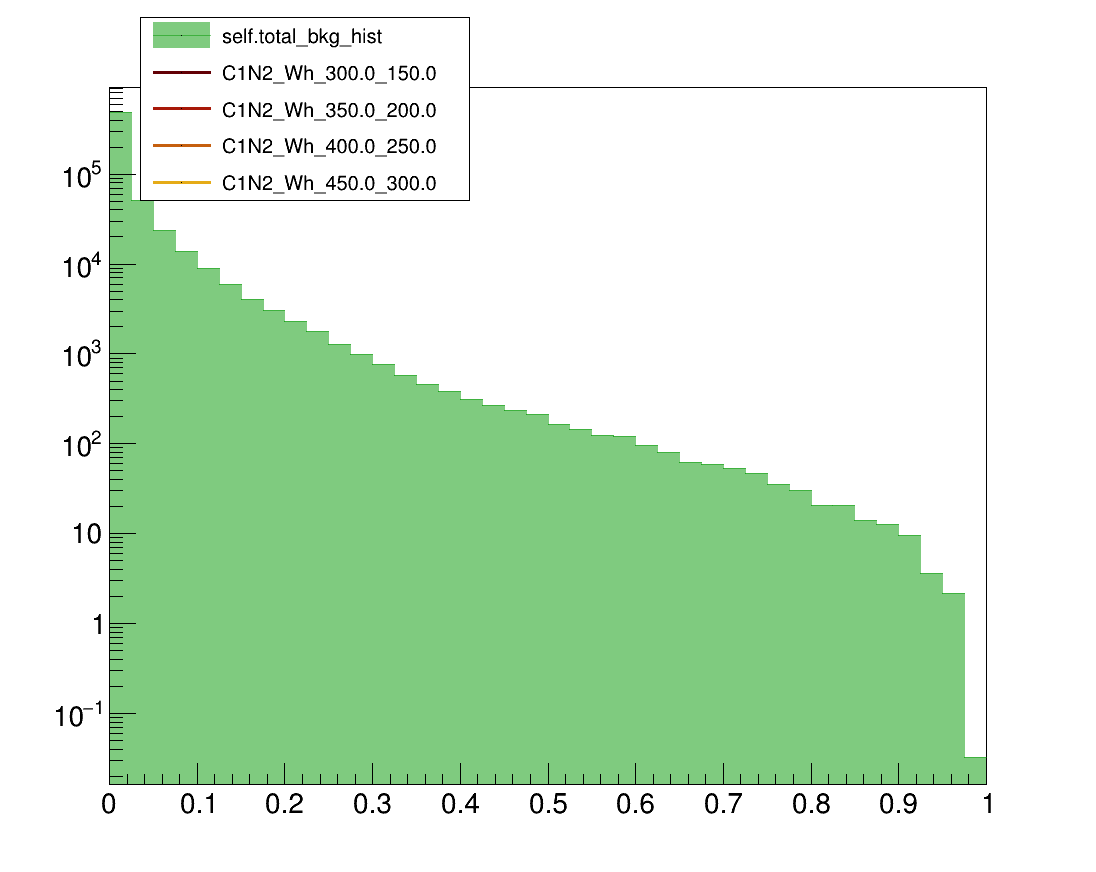

In [23]:
# import importlib
# importlib.reload(XGB_board)
# model.cuda()
# new_board = XGB_board.board_object(model,xmini=xmini, device=device, output_dir="temp/")
# new_board.get_inputs(train_loader, test_loader)
model.cpu()
c = board.draw_single_samples_root(signal_samples, to_load)
c.Draw()